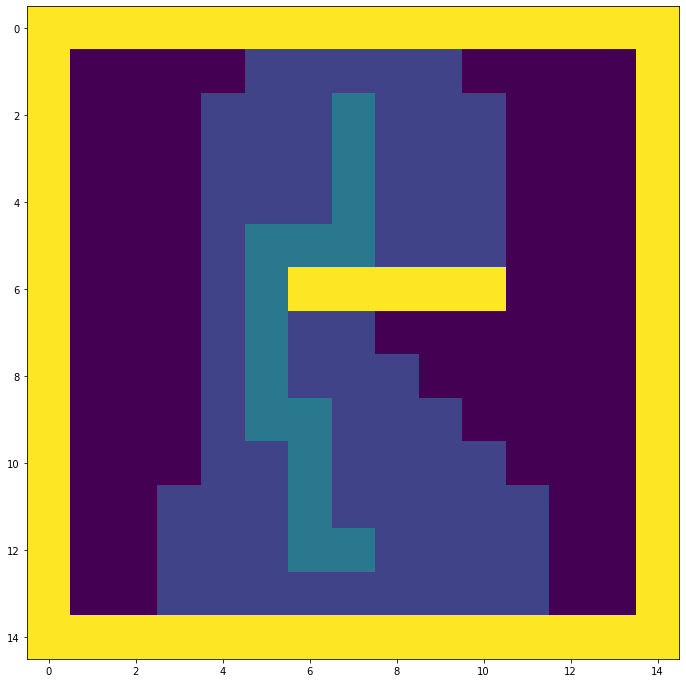

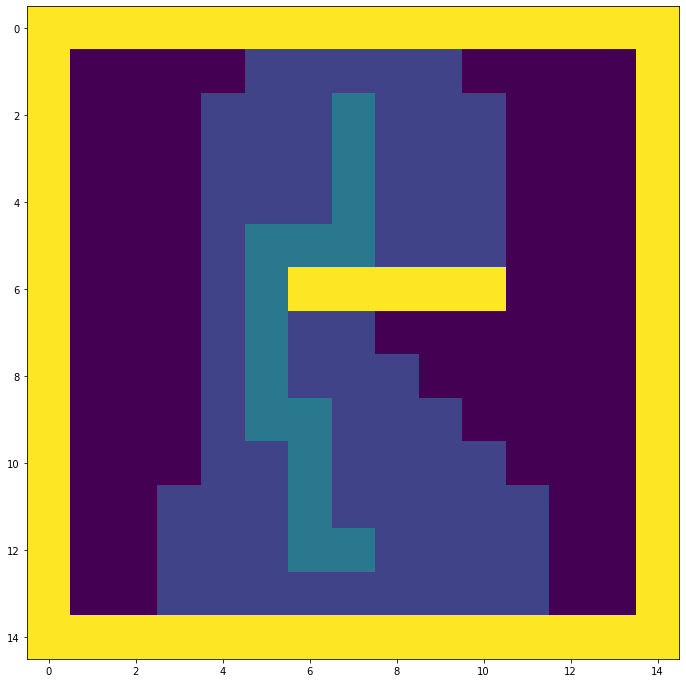

In [5]:
import heapq
import math
import matplotlib.pyplot as plt
import numpy as np
import math
import matplotlib
%matplotlib inline
#set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
plt.ion()
plt.figure(figsize=(12, 12))

"""

"""

class GridMap:
    def __init__(self, ox, oy, resolution):
        self.min_x = None
        self.min_y = None
        self.max_x = None
        self.max_y = None
        self.x_width = None
        self.y_width = None
        self.obstacle_map = None
        
        self.resolution = resolution
        self.calc_obstacle_map(ox, oy)
        
    def calc_obstacle_map(self, ox, oy):

        self.min_x = round(min(ox))
        self.min_y = round(min(oy))
        self.max_x = round(max(ox))
        self.max_y = round(max(oy))
        print("min_x:", self.min_x)
        print("min_y:", self.min_y)
        print("max_x:", self.max_x)
        print("max_y:", self.max_y)

        self.x_width = round((self.max_x - self.min_x) / self.resolution)+1
        self.y_width = round((self.max_y - self.min_y) / self.resolution)+1
        print("x_width:", self.x_width)
        print("y_width:", self.y_width)

        # obstacle map generation
        self.obstacle_map = np.zeros((self.x_width, self.y_width))
        for x, y in zip(ox, oy):
            ix, iy = self.calc_xy_index(x, self.min_x), self.calc_xy_index(y, self.min_y)
            if 0<=ix<self.x_width and 0<=iy<self.y_width:
                self.obstacle_map[ix, iy] = 10.0  
        

    def calc_position(self, index, minp):
        pos = index * self.resolution + minp
        return pos

    def calc_xy_index(self, position, minp):
        return round((position - minp) / self.resolution)
    
    def calc_unique_index(self, node):
        return node.iy*self.x_width + node.ix

    def verify_node(self, node):
        if node.ix >= self.x_width or node.ix < 0 or node.iy >= self.y_width or node.iy < 0:
            return False
        if abs(self.obstacle_map[node.ix, node.iy] - 10.0) < 0.01:
            return False        
        return True

sx = -5.0  # [m]
sy = -5.0  # [m]
gx = 50.0  # [m]
gy = 50.0  # [m]
grid_size = 5.0  # [m]
robot_radius = 1.0  # [m]

# set obstacle positions
ox, oy = [], []
for i in range(-10, 60):
    ox.append(i)
    oy.append(-10.0)
for i in range(-10, 60):
    ox.append(60.0)
    oy.append(i)
for i in range(-10, 61):
    ox.append(i)
    oy.append(60.0)
for i in range(-10, 61):
    ox.append(-10.0)
    oy.append(i)
# for i in range(-10, 40):
#     ox.append(20.0)
#     oy.append(i)
for i in range(20, 40):
    ox.append(20.0)
    oy.append(60.0 - i)    
grid_map = GridMap(ox, oy, grid_size)



class Node:
    def __init__(self, ix, iy, C=0.0, P=None):
        self.ix = ix
        self.iy = iy
        self.C = C
        self.P = P
        
action_set = {'UP':[0, 1], 'DOWN':[0, -1], 'LEFT':[-1, 0], 'RIGHT':[1, 0]}

def get_neighbors(current, grid_map):
    for a in action_set:
        node = Node(current.ix+action_set[a][0], 
                    current.iy+action_set[a][1], current.C+1.0, 
                    grid_map.calc_unique_index(current))
        if grid_map.verify_node(node):
            yield node
            
def get_heuristic(node, end_node):
    dx = node.ix - end_node.ix
    dy = node.iy - end_node.iy
    return np.sqrt(dx*dx+dy*dy)
        

    
def BAStar(grid_map, start_node, end_node):
    Closed_set_I, Open_set_I = {}, {}
    Closed_set_G, Open_set_G = {}, {}
    Open_set_I[grid_map.calc_unique_index(start_node)] = start_node
    Open_set_G[grid_map.calc_unique_index(end_node)] = end_node
    Q_I, Q_G = [],[]
    heapq.heappush(Q_I, (start_node.C+get_heuristic(start_node, end_node), 
                       grid_map.calc_unique_index(start_node)))
    heapq.heappush(Q_G, (end_node.C+get_heuristic(end_node, start_node), 
                       grid_map.calc_unique_index(end_node)))    
    while True:
        if not Open_set_I and not Open_set_G:
            print("Bidirectional A* Algorithm Finished.")
            return [], [], -1
        
        if Open_set_I:
            C, c_id = heapq.heappop(Q_I)        
            if c_id in Open_set_I:
                current = Open_set_I.pop(c_id)
                Closed_set_I[c_id] = current
                if c_id in Closed_set_G:
                    return ShortestPathFinder(grid_map, Closed_set_I, Closed_set_G, c_id)
            else:
                continue

            for node in get_neighbors(current, grid_map):
                neighbor_index = grid_map.calc_unique_index(node)
                if neighbor_index in Closed_set_I or neighbor_index in Closed_set_G: continue
                if neighbor_index not in Open_set_I or Open_set_I[neighbor_index].C > node.C:
                    Open_set_I[neighbor_index] = node
                    heapq.heappush(Q_I, (node.C+get_heuristic(node, end_node), neighbor_index))
                    grid_map.obstacle_map[node.ix, node.iy] = 2
            plt.clf()
            plt.imshow(grid_map.obstacle_map)
            if is_ipython:
                display.clear_output(wait=True)
                display.display(plt.gcf())        
            
        if Open_set_G:
            C, c_id = heapq.heappop(Q_G)        
            if c_id in Open_set_G:
                current = Open_set_G.pop(c_id)
                Closed_set_G[c_id] = current
                if c_id in Closed_set_I:
                    return ShortestPathFinder(grid_map, Closed_set_I, Closed_set_G, c_id)
            else:
                continue

            for node in get_neighbors(current, grid_map):
                neighbor_index = grid_map.calc_unique_index(node)
                if neighbor_index in Closed_set_I or neighbor_index in Closed_set_G: continue
                if neighbor_index not in Open_set_G or Open_set_G[neighbor_index].C > node.C:
                    Open_set_G[neighbor_index] = node
                    heapq.heappush(Q_G, (node.C+get_heuristic(node, end_node), neighbor_index))
                    grid_map.obstacle_map[node.ix, node.iy] = 2
            plt.clf()
            plt.imshow(grid_map.obstacle_map)
            if is_ipython:
                display.clear_output(wait=True)
                display.display(plt.gcf())        
import collections

def ShortestPathFinder(grid_map, Closed_set_I, Closed_set_G, c_id):
    print(Closed_set_I, Closed_set_G)
    print(c_id)
    if grid_map.verify_node(end_node) == False:
        print("the goal is unreachable!!!please change a reachable goal...")
        return [], [], -1
    
    SPath_x = collections.deque()
    SPath_y = collections.deque()

    SPath_x.append(Closed_set_I[c_id].ix)
    SPath_y.append(Closed_set_I[c_id].iy)
    
    u_I_id = Closed_set_I[c_id].P
    u_G_id = Closed_set_G[c_id].P 
    
    
    SPath_dist = (Closed_set_I[c_id].C+Closed_set_G[c_id].C)*grid_map.resolution    
    while u_I_id or u_G_id: 
        if u_I_id:
            SPath_x.append(Closed_set_I[u_I_id].ix)
            SPath_y.append(Closed_set_I[u_I_id].iy)
            u_I_id = Closed_set_I[u_I_id].P
        if u_G_id:
            SPath_x.appendleft(Closed_set_G[u_G_id].ix)
            SPath_y.appendleft(Closed_set_G[u_G_id].iy)                    
            u_G_id = Closed_set_G[u_G_id].P
    return SPath_x, SPath_y, SPath_dist

start_node = Node(2, 7)
end_node = Node(12, 7)
grid_map.obstacle_map[start_node.ix, start_node.iy] = 8
grid_map.obstacle_map[end_node.ix, end_node.iy] = 3
plt.imshow(grid_map.obstacle_map)

path_x, path_y, path_dist = BAStar(grid_map, start_node, end_node)
grid_map.obstacle_map[end_node.ix, end_node.iy] = 4
for ix, iy in zip(path_x, path_y):
    grid_map.obstacle_map[ix, iy] = 4
    
plt.clf()
plt.imshow(grid_map.obstacle_map)
if is_ipython:
    display.clear_output(wait=True)
    display.display(plt.gcf()) 